In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)  
old_shape = train_X.shape
print("old shape ", old_shape)
old_test_X = test_X.copy()  
train_X, test_X = prepare_for_neural_network(train_X, test_X)

# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

old shape  (10000, 32, 32, 3)


Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:

прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам
Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3], [-1, 2, 0.1]])

assert check_layer_gradient(ReLULayer(), X)

CHECK GRADIENT
x is 
 [[ 1.  -2.   3. ]
 [-1.   2.   0.1]]
analytic grad is 
 [[ 1.61599406  0.          2.76252524]
 [-0.         -0.5060347  -0.94302519]]
numeric grad array is 
 [[ 1.61599406  0.          2.76252524]
 [ 0.         -0.5060347  -0.94302519]]
Gradient check passed!


In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

CHECK GRADIENT
x is 
 [[ 1.  -2.   3. ]
 [-1.   2.   0.1]]
analytic grad is 
 [[ 4.18948095e-04  1.76337767e-03 -3.49979411e-04]
 [ 7.82747412e-05 -6.12293143e-04 -1.09946675e-03]]
numeric grad array is 
 [[ 4.18948095e-04  1.76337767e-03 -3.49979411e-04]
 [ 7.82747412e-05 -6.12293143e-04 -1.09946675e-03]]
Gradient check passed!
CHECK GRADIENT
x is 
 [[-1.97365551e-03  6.80635002e-04  5.55869402e-05  5.41565103e-04]
 [ 1.83213048e-04 -5.59157557e-04  8.94307167e-04  1.98126611e-04]
 [-1.28938649e-03  1.30851716e-03 -1.43047956e-03  9.00929234e-04]]
analytic grad is 
 [[-1.67429365  2.15318718 -0.15893916 -0.56958173]
 [ 3.34858731 -4.30637437  0.31787831  1.13916345]
 [-0.36258122  5.45842018 -3.37773459 -0.89339967]]
numeric grad array is 
 [[-1.67429365  2.15318718 -0.15893916 -0.56958173]
 [ 3.34858731 -4.30637437  0.31787831  1.13916345]
 [-0.36258122  5.45842018 -3.37773459 -0.89339967]]
Gradient check passed!
CHECK GRADIENT
x is 
 [[-1.33418835e-03  2.29823155e-04  1.28956322e-03

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
batch_size = 2
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:batch_size], train_y[:batch_size])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:batch_size], train_y[:batch_size])

Checking gradient for W1
CHECK GRADIENT
x is 
 [[ 5.55132245e-04 -8.29725676e-04 -9.95647818e-04]
 [ 7.71607110e-04  8.55758768e-04 -1.27373828e-03]
 [-1.23679768e-03 -4.45049694e-04 -7.11304833e-04]
 ...
 [-1.27559794e-03 -5.69992050e-04  4.02575187e-04]
 [ 2.28669670e-04  1.30825243e-03  7.03814008e-06]
 [-1.76402810e-04 -1.57398266e-03 -8.06722910e-04]]
analytic grad is 
 [[ 2.10787160e-05  0.00000000e+00 -4.47056165e-05]
 [ 2.51157965e-05  0.00000000e+00 -9.99876323e-06]
 [ 7.14281875e-05  0.00000000e+00  8.78028877e-05]
 ...
 [-1.96137432e-04  0.00000000e+00 -1.67966637e-04]
 [-1.75261159e-04  0.00000000e+00 -1.05706581e-04]
 [-1.39601392e-04  0.00000000e+00 -5.89752946e-06]]
numeric grad array is 
 [[ 2.10787388e-05  0.00000000e+00 -4.47056170e-05]
 [ 2.51157761e-05  0.00000000e+00 -9.99875738e-06]
 [ 7.14281967e-05  0.00000000e+00  8.78028317e-05]
 ...
 [-1.96137417e-04  0.00000000e+00 -1.67966618e-04]
 [-1.75261183e-04  0.00000000e+00 -1.05706555e-04]
 [-1.39601397e-04  0.00000

True

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W1
CHECK GRADIENT
x is 
 [[-9.88162631e-04 -5.62436018e-05 -1.06671111e-03]
 [ 7.69188816e-04  4.08942767e-04  5.49801863e-04]
 [ 1.13086936e-03 -3.37809772e-04  1.07450757e-03]
 ...
 [-4.79073444e-04  3.42822914e-04 -1.04962798e-04]
 [ 1.54995685e-03 -3.56086006e-04  4.46385075e-04]
 [ 1.08696651e-03  6.55927424e-04  5.42182697e-04]]
analytic grad is 
 [[-0.01976325 -0.00123181 -0.02137282]
 [ 0.01538378  0.00813634  0.01095005]
 [ 0.02261739 -0.00664902  0.02135936]
 ...
 [-0.00958147  0.00670568 -0.00174011]
 [ 0.03099914 -0.00716936  0.00924862]
 [ 0.02173933  0.01323425  0.01109928]]
numeric grad array is 
 [[-0.01976325 -0.00123181 -0.02137282]
 [ 0.01538378  0.00813634  0.01095005]
 [ 0.02261739 -0.00664902  0.02135936]
 ...
 [-0.00958147  0.00670568 -0.00174011]
 [ 0.03099914 -0.00716936  0.00924862]
 [ 0.02173933  0.01323425  0.01109928]]
Gradient check passed!
Checking gradient for B1
CHECK GRADIENT
x is 
 [[-0.00050679  0.00011694  0.0004614 ]]
analytic

True

In [8]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

**Допишем код для процесса тренировки**


Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [64]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), num_epochs =20, batch_size=20, learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

X shape is
 (9000, 3072)
y shape is
 (9000,)
Loss: 45.567228, Train accuracy: 0.339222, val accuracy: 0.339000
Loss: 36.135920, Train accuracy: 0.487778, val accuracy: 0.484000
Loss: 25.367423, Train accuracy: 0.620667, val accuracy: 0.602000
Loss: 21.476445, Train accuracy: 0.691333, val accuracy: 0.663000
Loss: 16.547859, Train accuracy: 0.689556, val accuracy: 0.644000
Loss: 25.446648, Train accuracy: 0.676444, val accuracy: 0.640000
Loss: 16.990218, Train accuracy: 0.754889, val accuracy: 0.699000
Loss: 17.879997, Train accuracy: 0.756111, val accuracy: 0.700000
Loss: 24.331481, Train accuracy: 0.726222, val accuracy: 0.654000
Loss: 22.503122, Train accuracy: 0.737667, val accuracy: 0.683000
Loss: 28.128872, Train accuracy: 0.738222, val accuracy: 0.664000
Loss: 16.928348, Train accuracy: 0.777222, val accuracy: 0.704000
Loss: 26.261629, Train accuracy: 0.777889, val accuracy: 0.687000
Loss: 20.079861, Train accuracy: 0.816444, val accuracy: 0.713000
Loss: 24.924250, Train accuracy

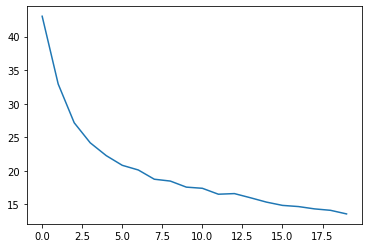

In [65]:
plt.plot(loss_history)
# plt.plot(train_history)
# plt.plot(val_history)

test x is  (1000, 3072)
test pred is 
 [2 1 3 2 2 5 7 1 7 1]
test_y  is 
 [2 1 3 0 2 5 0 1 7 1]


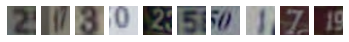

Neural network classifier test set accuracy: 68.600000


In [66]:
# model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)


number = 10
print("test x is ", test_X.shape)
test_pred = model.predict(test_X[:number])
print("test pred is \n", test_pred)
print("test_y  is \n", test_y[:number])
plot_index = 1
for class_index in range(number):
        plt.subplot(1, number, plot_index)
        
        image = old_test_X[class_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

plt.show()
# print("test pred is \n", test_pred[:number])

test_pred = model.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)*100
print('Neural network classifier test set accuracy: %f' % (test_accuracy, ))

In [62]:

X = np.array([[1,-2,3],
              [-1, 2, 0.1]])

Y = np.array([[1,3,3],
              [-1, 2, 0.1]])
# print(X*Y)

# lst = [a, 4,3]
mapa = {'X': X, 'Y': Y}
# print("loss is ", loss)

loss_lst = [np.sum(param**2) for param in mapa.values()]
loss =  sum(loss_lst)

# reg_loss_params = {key: np.sum(param) for key, param in mapa.items()}
# reg_loss = sum(reg_loss_params.values())
# X= X**2
# X.fill(0)
print("X is \n", X)
print("mapa is \n", mapa)
# print("reg loss params is\n", reg_loss_params)
print("loss lst\n", loss_lst)
print("loss ", loss)

X is 
 [[ 1.  -2.   3. ]
 [-1.   2.   0.1]]
mapa is 
 {'X': array([[ 1. , -2. ,  3. ],
       [-1. ,  2. ,  0.1]]), 'Y': array([[ 1. ,  3. ,  3. ],
       [-1. ,  2. ,  0.1]])}
loss lst
 [19.01, 24.01]
loss  43.02
